In [1]:
!pip install pandas
!pip install matplotlib

   ---------------------------------------- 0.0/11.5 MB ? eta -:--:--
    --------------------------------------- 0.3/11.5 MB ? eta -:--:--
   - -------------------------------------- 0.5/11.5 MB 1.2 MB/s eta 0:00:10
   -- ------------------------------------- 0.8/11.5 MB 1.2 MB/s eta 0:00:10
   -- ------------------------------------- 0.8/11.5 MB 1.2 MB/s eta 0:00:10
   --- ------------------------------------ 1.0/11.5 MB 1.0 MB/s eta 0:00:11
   ---- ----------------------------------- 1.3/11.5 MB 1.0 MB/s eta 0:00:10
   ----- ---------------------------------- 1.6/11.5 MB 1.1 MB/s eta 0:00:09
   ------ --------------------------------- 1.8/11.5 MB 1.1 MB/s eta 0:00:09
   ------- -------------------------------- 2.1/11.5 MB 1.2 MB/s eta 0:00:08
   ------- -------------------------------- 2.1/11.5 MB 1.2 MB/s eta 0:00:08
   ------- -------------------------------- 2.1/11.5 MB 1.2 MB/s eta 0:00:08
   ------- -------------------------------- 2.1/11.5 MB 1.2 MB/s eta 0:00:08
   ------- --


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   --- ------------------------------------ 0.8/8.1 MB 4.9 MB/s eta 0:00:02
   --------- ------------------------------ 1.8/8.1 MB 5.1 MB/s eta 0:00:02
   -------------- ------------------------- 2.9/8.1 MB 5.0 MB/s eta 0:00:02
   ------------------- -------------------- 3.9/8.1 MB 4.9 MB/s eta 0:00:01
   ----------------------- ---------------- 4.7/8.1 MB 4.6 MB/s eta 0:00:01
   --------------------------- ------------ 5.5/8.1 MB 4.4 MB/s eta 0:00:01
   ------------------------------- -------- 6.3/8.1 MB 4.3 MB/s eta 0:00:01
   --------------------------------- ------ 6.8/8.1 MB 4.1 MB/s eta 0:00:01
   ---------------------------------------  7.9/8.1 MB 4.2 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 4.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   --------- ------------------------------ 0.5/2.2 MB 3.4 MB/s eta 0:00:01
   -----------------------


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import os 
from datetime import datetime,timedelta
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

#Caminho para os dados. A estrutura das pastas deve seguir:
# path_to_data
#   |-- 1 (Pasta contendo dados colhidos com o algoritmo 1 de leitura - liga sensor, faz leitura, desliga sensor)
#       |-- 1.0.csv
#       |-- 1.1.csv
#       |-- 1.2.csv
#           ...
#   |-- 2 (Pasta contendo dados colhidos com o algoritmo 2 de leitura - liga sensor, aguarda X segundos, faz leitura, desliga sensor)
#       |-- 2.0.csv
#       |-- 2.1.csv
#       |-- 2.2.csv
#           ...
#   |-- 3 (Pasta contendo dados colhidos com o algoritmo 3 de leitura - liga sensor, aguarda X segundos, faz N leituras, desliga sensor)
#       |-- 3.0.csv
#       |-- 3.1.csv
#       |-- 3.2.csv
#           ...

path_to_data = "dados"

path = os.path.join(path_to_data,"1")
df1 = None
for file in os.listdir(path):
    if file.endswith(".csv"):
        try:
            cur_pd = pd.read_csv(path + '\\' + file)
        except:
            print(file)
            raise
        if 'ts' in cur_pd.columns:
            cur_pd['ts'] = pd.to_datetime(cur_pd['ts'], format='%y-%m-%d %H:%M:%S')
        if df1 is None:
            df1 = cur_pd
        else:
            df1 = pd.concat([df1,cur_pd])

path = os.path.join(path_to_data,"2")
df2 = None
for file in os.listdir(path):
    if file.endswith(".csv"):
        try:
            cur_pd = pd.read_csv(path + '\\' + file)
        except:
            print(file)
            raise
        if 'ts' in cur_pd.columns:
            cur_pd['ts'] = pd.to_datetime(cur_pd['ts'], format='%y-%m-%d %H:%M:%S')
        if df2 is None:
            df2 = cur_pd
        else:
            df2 = pd.concat([df2,cur_pd])

path = os.path.join(path_to_data,"3")
df3 = None
for file in os.listdir(path):
    if file.endswith(".csv"):
        try:
            cur_pd = pd.read_csv(path + '\\' + file)
        except:
            print(file)
            raise
        if 'ts' in cur_pd.columns:
            cur_pd['ts'] = pd.to_datetime(cur_pd['ts'], format='%y-%m-%d %H:%M:%S')
        if df3 is None:
            df3 = cur_pd
        else:
            df3 = pd.concat([df3,cur_pd])

dict_id_sType = {
    2:"SHT45",
    3:"CWT",
    7:"SHT45",
    9:"CWT",
    11:"Roxo",
    12:"Roxo",
    14:"Roxo",
    19:"Verde",
    20:"Verde",
    21:"Verde",
    23:"THC",
    24:"THC",
    26:"THC",
    27:"THC",
    28:"EC5",
    30:"PCB capacitivo"
}

#Remove dados inconsistentes
date_init= pd.to_datetime('24-01-02 13:00:00', format='%y-%m-%d %H:%M:%S')

df1 = df1[df1['ts'] > date_init]
df2 = df2[df2['ts'] > date_init]
df3 = df3[df3['ts'] > date_init]

In [ ]:
# Lê os dados do sensor de referência
path = 'ref\\ref.csv'
df_ref = pd.read_csv(path)
df_ref['ts'] = pd.to_datetime(df_ref['ts'], format='%y-%m-%d %H:%M:%S')

In [110]:

def plot(ids,alg = 2,calc_strategies_diff = False,date_init = None,ytext = 2,unit="%",dot_size = 10,title=None):
    """
    Plota os dados dos sensores de umidade em função do tempo.
    ids: lista de ids dos sensores a serem plotados
    alg: algoritmo a ser utilizado para plotar os dados. 1 - Algoritmo 1, 2 - Algoritmo 2, 3 - Algoritmo 3
    calc_strategies_diff: booleano indicando se deve ser calculada a diferença entre as estratégias 1 e 2
    date_init: data inicial para o plot. Se None, não é filtrada.
    ytext: valor a ser adicionado ao eixo y para o texto de anotação
    unit: unidade de medida a ser utilizada no eixo y
    """
    
    #Coluna a ser plotada
    column = "humidity"
    import matplotlib.pyplot as plt

    # Set the x-axis limits to start from 0
    
    plt.figure(figsize=(20,6))

    if title is None:
        if len(ids) > 1:
            title = "Sensores: "
        else:
            title = "Sensor: "

        for i in range(len(ids)-1):
            title += str(ids[i]) + ', '

        title += str(ids[-1])

    plt.title(title)

    plt.xlabel("i-ésima medição")
    plt.ylabel(f"Umidade ({unit})")

    #Array de cores para plotar mais de uma curva no mesmo gráfico
    colors = plt.cm.tab20.colors + plt.cm.tab20b.colors[:4]

    #Primeira curva será plotada na cor colors[0]
    color = 0

    #Para cada um dos sensores
    for id in ids:
        if alg == 1: #Plotar curvas do algoritmo 1
            df = df1
            if date_init is not None:
                try: 
                    date_init = pd.to_datetime(date_init, format='%y-%m-%d')
                    df = df[df['ts']>date_init]
                except:
                    pass
            plt.scatter(x = [i for i in range(df[df['id'] == id].shape[0])], y = df[df['id'] == id].sort_values('ts',axis='index',ascending=True)[column],color='blue')
            
        if alg == 2: #Plotar curvas do algoritmo 2
            df = df2
            if date_init is not None:
                try: 
                    date_init = pd.to_datetime(date_init, format='%y-%m-%d')
                    df = df[df['ts']>date_init]
                except:
                    df = df2
            color = (color+1)%len(colors)
            plt.scatter(x=[i for i in range(df[df['id'] == id].shape[0])], 
                        y=df[df['id'] == id].sort_values('ts', axis='index', ascending=True)[column], 
                        color=colors[color], label=f"ID {id}", s=dot_size)
            
    #Pega a curva do primeiro id como referência para plotar as marcações temporais. Isso pode ser feito uma vez que a data da i-ésima medição de cada sensor foi realizado 
    #aproximadamente no mesmo horário.
    df = df2[df2['id'] == ids[0]].sort_values('ts',axis='index',ascending=True)[[column,'ts']]  

    #Reseta os índices
    df.reset_index(drop=True, inplace=True)
    
    #Como a leitura do sensor de referência não acompanhou a frequência de leitura dos outros sensores, é necessário fazer o mesmo processo de reset de índice
    #Então, pela data de cada medição de referÊncia, é possível encontrar o índice da medição mais próxima do sensor não-referência.
    df_ref['i_index'] = df_ref['ts'].apply(lambda x: (df['ts'] - x).abs().idxmin())

    # Plota a curva do sensor de referência
    plt.plot(df_ref['i_index'], df_ref['humidity'], linestyle='--', color='black', label='Sensor de Referência', linewidth=2)

    #Realiza as marcações semanais no gráfico    
    if date_init is not None:
        try: 
            date_init = pd.to_datetime(date_init, format='%y-%m-%d')
            df = df[df['ts']>date_init]
        except:
            df = df2[df2['id'] == id].sort_values('ts',axis='index',ascending=True)[[column,'ts']]

    #Marcações temporais a cada 2500 medições
    for i in range(1,df.shape[0],2500):
        plt.axvline(x=i, color='gray', linestyle='--', linewidth=0.8)
        plt.annotate(
            df.iloc[i]['ts'].strftime('%d/%m/%y'),  # Date text
            xy=(i, 80),  # Point to annotate
            xytext=(i + 5, 80 + ytext),  # Text position
            arrowprops=dict(facecolor='black', arrowstyle='->'),  # Arrow style
            fontsize=8, color='gray'
        )

    #Deviation between strategies 1 and 2 calculation
    legend_text = None
    if calc_strategies_diff:
        diff_sum = 0
        total = 0
        df_st_1 = df1[df1['id'] == id].sort_values('ts',axis='index',ascending=True)
        df_st_2 = df2[df2['id'] == id].sort_values('ts',axis='index',ascending=True)

        for i in range(df_st_1.shape[0]):
            if i < df_st_2.shape[0]:
                diff_sum += df_st_2['humidity'].iloc[i] - df_st_1['humidity'].iloc[i]
                total += 1
            else:
                break
        legend_text = Line2D([0], [0], linestyle="none", label=f'Estratégia 2 - Estratégia 1 (Média) : {diff_sum/total}')
    
    #Legend
    if calc_strategies_diff:
        plt.legend(handles=plt.gca().get_legend_handles_labels()[0] + [legend_text], title="Legend")
    else:
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1), markerscale=5)

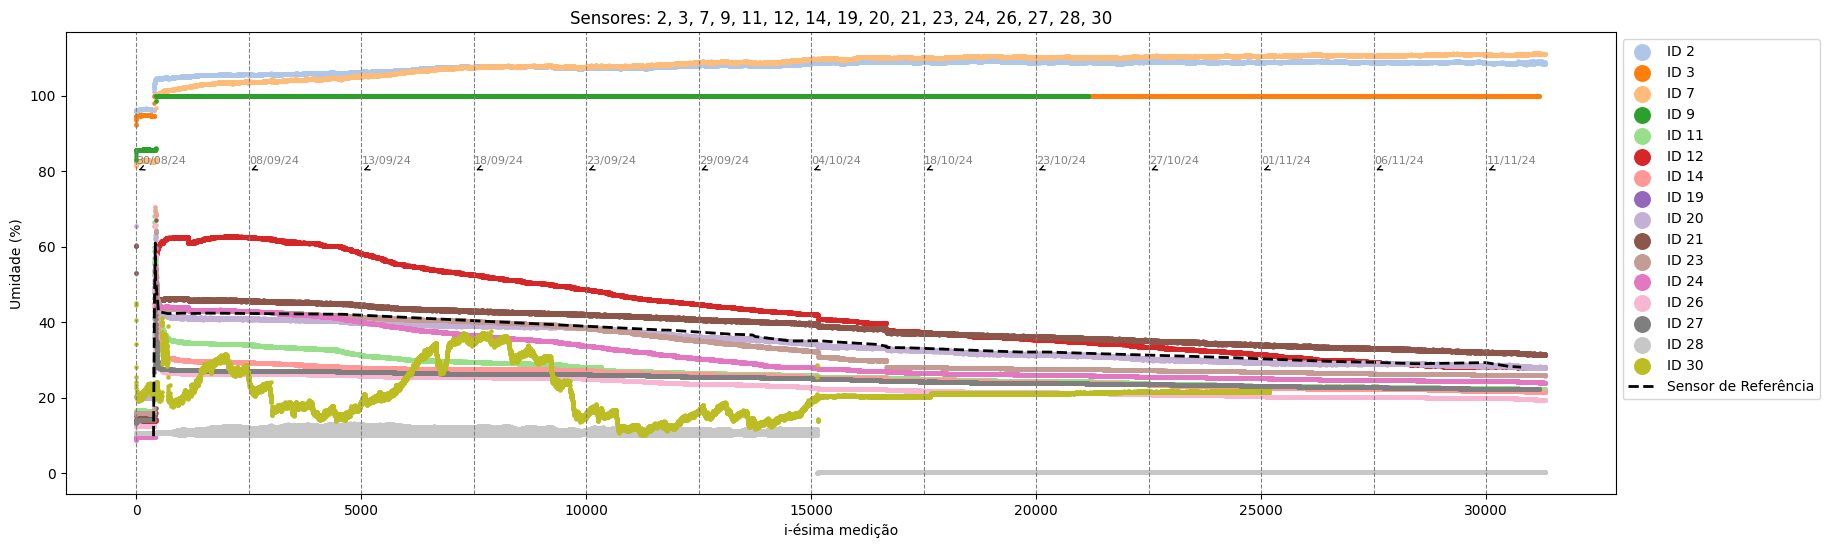

In [111]:
plot(list(dict_id_sType.keys()),alg=2,calc_strategies_diff=False,ytext=2,unit="%",dot_size=5)